In [1]:
import sys
sys.path.insert(1, '/home/ias627/tools')

In [2]:
from abg_python.snapshot_utils import openSnapshot
from abg_python.cosmo_utils import load_AHF
import numpy as np
import matplotlib.pyplot as plt

In [3]:
officialSimNames = {'h206':'A1',
                    'h29':'A2',
                    'h113':'A4',
                    'h2':'A8'}
simNameBase = '_HR_sn1dy300ro100ss'

In [4]:
def inrange(a, ra):
    a1, a2 = ra
    return (a1 <= a)&(a <= a2)

In [5]:
def load_p0(simName, snapnum):
    p0 = openSnapshot(f'/projects/b1026/anglesd/FIRE/{simName}', snapnum, 0, loud=1)
    
    print(f"Loading redshift {p0['Redshift']}")

    posC, Rvir = load_AHF('', snapnum, p0['Redshift'], hubble=p0['HubbleParam'], ahf_path=f'/projects/b1026/halo_files/anglesd_m13/{simName}', extra_names_to_read=[])

    # position relative to center
    p0['CoordinatesRelative'] = p0['Coordinates'] - posC

    # distance from halo center
    p0['r'] = np.linalg.norm(p0['CoordinatesRelative'], axis=1)

    # distance from halo center in units of virial radius
    p0['r_scaled'] = p0['r']/Rvir

    # volume of each particle
    p0['Vi'] = p0['Masses']/p0['Density']
    
    return p0

In [6]:
def logTavgGen( p0, Tmask=True, rbins=np.power(10, np.arange(np.log10(0.005258639741921723), np.log10(1.9597976388995666), 0.05)) ):
    '''
    Default Tmask and rbins chosen to match Stern+20 Fig. 6.
    '''
    rmid = (rbins[:-1]+rbins[1:])/2
    logTavgbins = []

    for r0,r1 in zip(rbins[:-1],rbins[1:]):
        idx = np.flatnonzero(Tmask & inrange( p0['r_scaled'], (r0, r1) ))
        logTavg = np.sum(np.log10(p0['Temperature'][idx]) * p0['Vi'][idx]) / np.sum(p0['Vi'][idx])
        logTavgbins.append(logTavg)
    return rmid, logTavgbins

In [7]:
#Tmask = True#p0['Temperature'] >= 1e5

## No-feedback runs at z=1

In [8]:
data_allsims = {}
for simTag in officialSimNames.keys():
    simName = simTag + simNameBase
    p0 = load_p0(simName, 277)
    rmid, logTavgbins = logTavgGen(p0)
    data_allsims[simTag]= (p0, rmid, logTavgbins)

/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.3.hdf5
Loading redshift 1.0000000007662364
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.3.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.4.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277

Text(0.5, 1.0, '$z=1.0$')

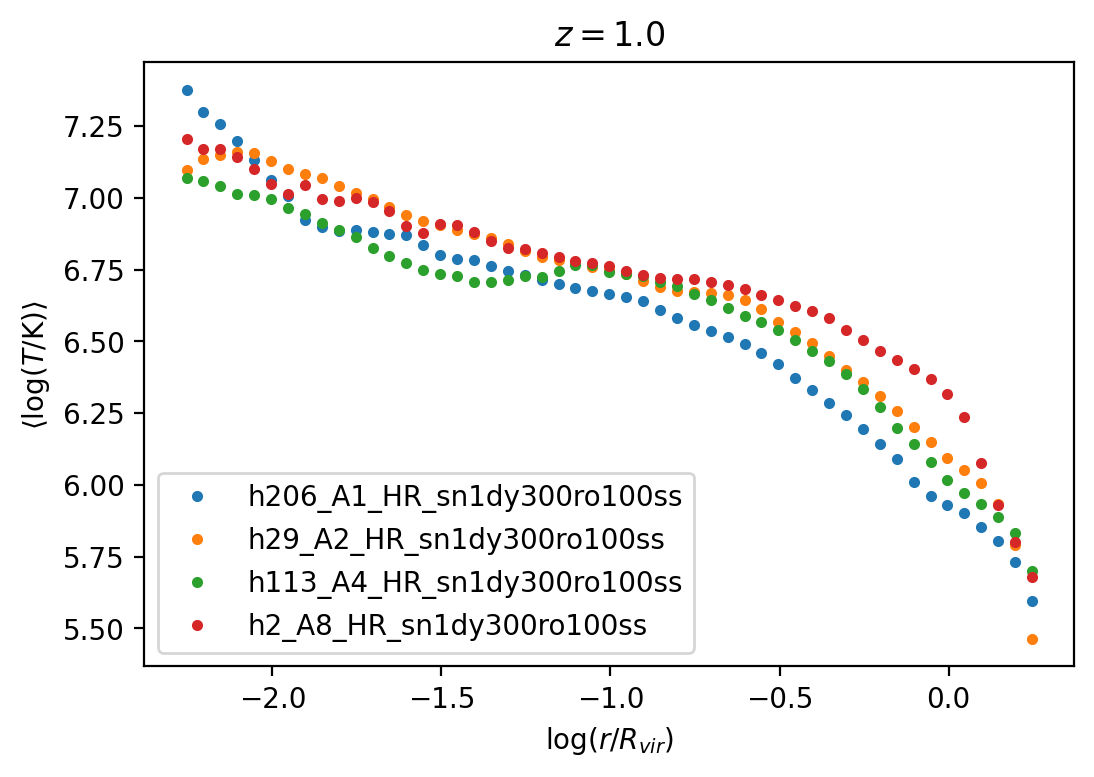

In [9]:
plt.figure(dpi=200)

for simTag, (p0, rmid, logTavgbins) in data_allsims.items():
    plt.plot(np.log10(rmid), logTavgbins, '.', label=f'{simTag}_{officialSimNames[simTag]}{simNameBase}')
    assert np.round(p0["Redshift"],2)==1.00
    
plt.xlabel(r'$\log (r/R_{vir})$')
plt.ylabel(r'$\left<\log \left(T/\mathrm{K}\right)\right>$')
plt.legend()
plt.title(f'$z={np.round(p0["Redshift"],2)}$')

## A8 z=1 comparison with Stern+20 z=1.1

Text(0.5, 1.0, '$z=1.0$')

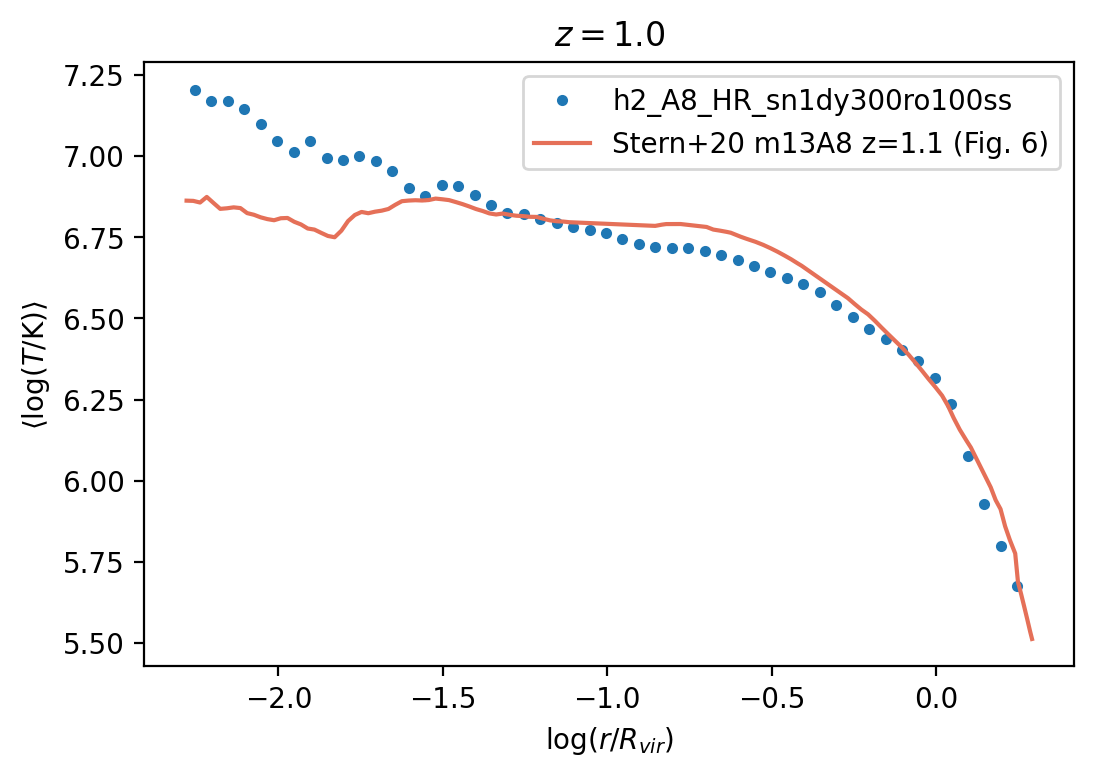

In [10]:
p0, rmid, logTavgbins = data_allsims['h2']

plt.figure(dpi=200)
plt.plot(np.log10(rmid), logTavgbins, '.', label=f'{simTag}_{officialSimNames[simTag]}{simNameBase}')

x_fid,y_fid = np.loadtxt('Stern20_Fig6_m13A8_Tavg_z1.1.csv', delimiter=',').T
plt.plot(np.log10(x_fid),np.log10(y_fid), label='Stern+20 m13A8 z=1.1 (Fig. 6)', c='#e57058')

plt.xlabel(r'$\log (r/R_{vir})$')
plt.ylabel(r'$\left<\log \left(T/\mathrm{K}\right)\right>$')
plt.legend()
plt.title(f'$z={np.round(p0["Redshift"],2)}$')